# Interactive effects model for housing prices

$$
log(SP)_i \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha_{NH[j]} + \beta * log(LA)_i \\
\alpha_j\sim Normal(1, 0.5),\space for\space j = 1...J\space neighbourhoods\\
\beta\sim Normal(0, 0.5) \\
\sigma\sim exp(1)
$$

In [32]:
import math
import pystan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

az.style.use('arviz-darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Train/Test data
train = pd.read_csv('../../data/raw/train.csv').assign(data_type = 'train')
test = pd.read_csv('../../data/raw/test.csv').assign(data_type = 'test')

# Want to ensure the encodings of the neighbourhoods as indexes are consistent
df_full = train.append(test, ignore_index = True)
df_full['neighbourhood'] = df_full['Neighborhood'].astype('category').cat.codes+1

# Log variables
df_full['log_sales_price'] = np.log(df_full['SalePrice'])
df_full['log_lot_area'] = np.log(df_full['LotArea'])

# Train/test split
train = df_full.loc[df_full['data_type'] == 'train'].copy()
test = df_full.loc[df_full['data_type'] == 'test'].copy()

# Center and scale predictor (train)
train['log_lot_area_z'] = (train[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target (train)
#train['log_sales_price_std'] = train['log_sales_price']/train['log_sales_price'].mean()
train['log_sales_price_std'] = (train[['log_sales_price']] - train[['log_sales_price']].mean()) / train[['log_sales_price']].std()

# Center and scale predictor using training data mean and std
test['log_lot_area_z'] = (test[['log_lot_area']] - train[['log_lot_area']].mean()) / train[['log_lot_area']].std()

# Scale target using training data mean
test['log_sales_price_std'] = test['log_sales_price']/train['log_sales_price'].mean()

## Load and simulate fake data

In [33]:
# Import dummy variable model
interactive_effects_model = pystan.StanModel(file = '../../models/saturated_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fd26cbcc911ebdb85f84ac295e847aae NOW.


In [34]:
# Set parameters
alpha_sd = 1
beta_sd = 1
bAN_sd = 1
sigma_sd = 1

In [35]:
iem_data_check = dict(N = len(train),
                      neighbourhood = train['neighbourhood'],
                      N_neighbourhood = len(train['Neighborhood'].unique()),
                      log_sales_price = train['log_sales_price_std'],
                      log_lot_area = train['log_lot_area_z'],
                      N_test = len(test),
                      neighbourhood_test = test['neighbourhood'],
                      log_lot_area_test = test['log_lot_area_z'],                         
                      alpha_sd = alpha_sd,
                      beta_sd = beta_sd,
                      sigma_sd = sigma_sd,
                      bAN_sd = bAN_sd,
                      run_estimation = 0)

fit_iem_check = interactive_effects_model.sampling(data=iem_data_check)
fit_iem_df_check = fit_iem_check.to_dataframe()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Traceplots

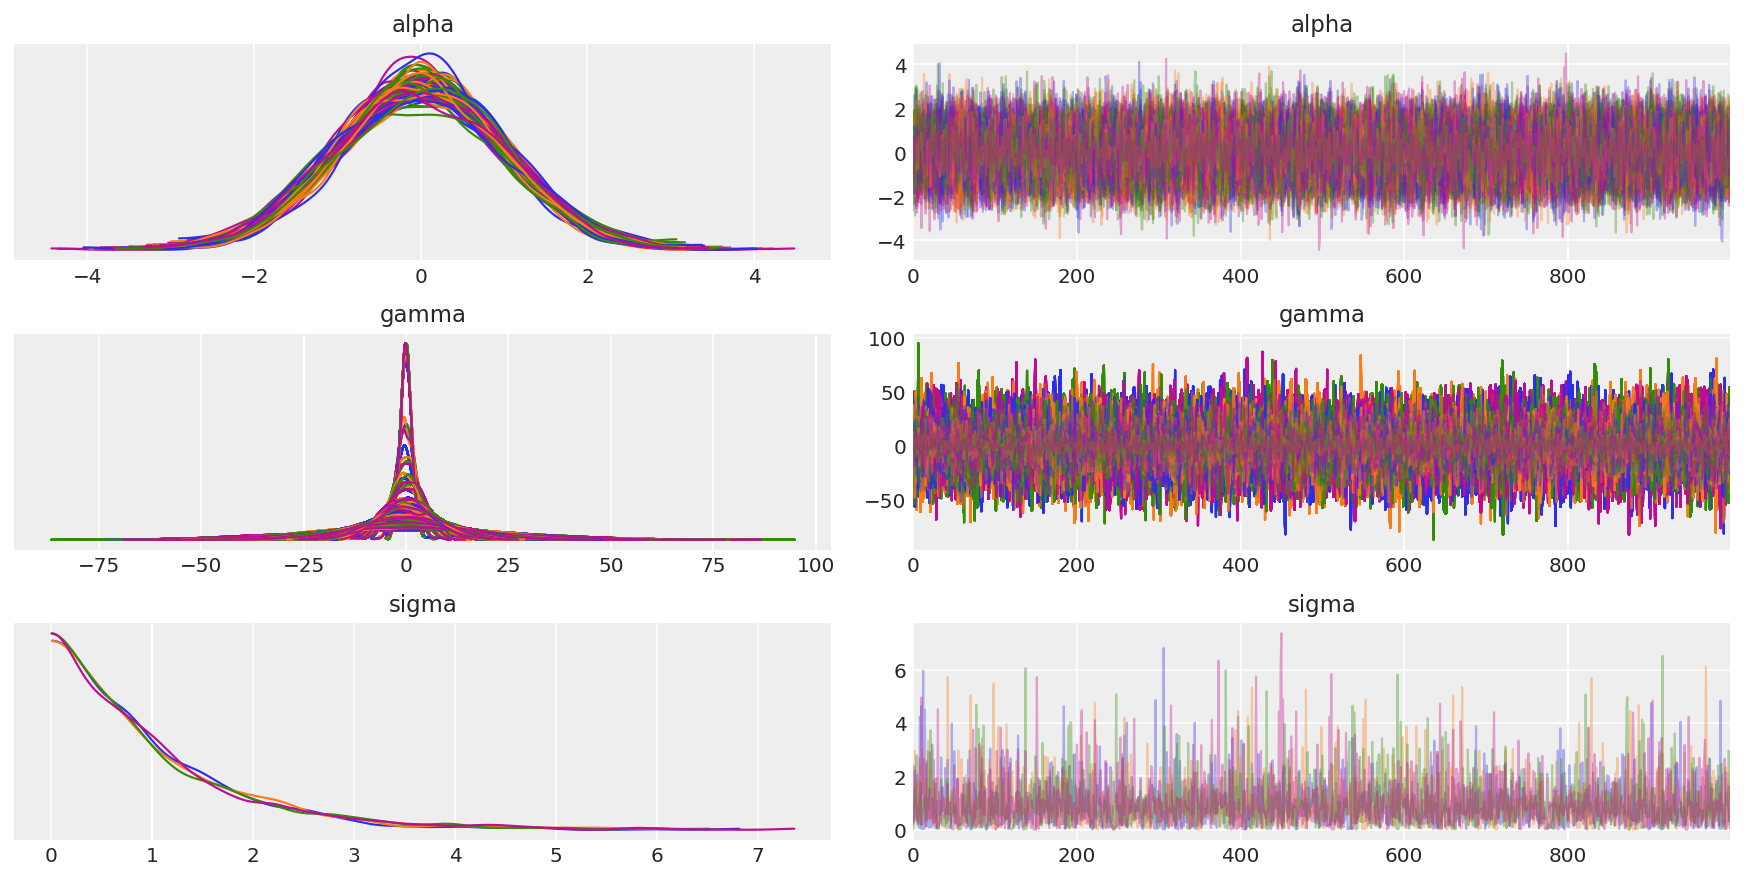

In [36]:
az.plot_trace(fit_iem_check, 
              var_names=["alpha", "gamma", "sigma"], 
              compact = True,
              chain_prop = 'color');

## Prior predictive checks

In [19]:
fit_iem_df_check.filter(regex = 'bA')

,bAN[1],bAN[2],bAN[3],bAN[4],bAN[5],bAN[6],bAN[7],bAN[8],bAN[9],bAN[10],...,bAN[17],bAN[18],bAN[19],bAN[20],bAN[21],bAN[22],bAN[23],bAN[24],bAN[25],bA
0,-0.156184,-0.371682,0.204234,-0.577779,0.069635,0.525221,-0.854921,-0.749475,0.843450,0.834175,...,-0.993650,1.112290,0.164620,-0.606723,1.804578,-0.768174,0.633754,0.070430,-1.103551,-1.309331
1,0.126397,0.382688,-0.115489,0.490207,-0.069469,-0.555306,0.968991,0.891335,-0.757756,-0.664564,...,1.057974,-0.907581,0.066901,0.622783,-1.883859,0.727069,-0.736219,0.141906,1.110933,1.412620
2,-0.234468,-0.422948,0.213252,-0.470360,0.069968,0.780942,-0.931567,-0.754253,0.623757,0.753337,...,-1.352241,0.962664,-0.242892,-0.595848,1.908876,-0.921985,0.523859,0.113651,-1.112615,-1.310787
3,0.469019,0.434108,-0.171354,0.542213,-0.069953,-0.735263,1.182258,0.673561,-0.376250,-0.732747,...,1.352391,-0.656798,0.071016,0.600670,-1.880527,0.845280,-0.884641,-0.530452,1.101246,1.293876
4,0.647719,0.146795,0.285595,0.206621,0.942248,-0.219632,2.015272,0.338888,-1.121613,0.338061,...,0.526752,0.428272,0.084427,-0.539365,-2.350514,0.005507,0.476536,1.070599,-1.037896,0.411466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.992695,-0.262586,0.447119,-0.056782,0.294952,0.173701,-0.806248,-2.075602,1.046133,0.792019,...,0.461194,0.265845,0.802920,-1.451798,0.931089,-0.344660,1.101060,-0.196903,-0.663851,0.173708
3996,-0.967832,-1.079273,0.546660,-0.149511,2.460877,-2.024479,-0.398144,1.227834,0.968848,0.873230,...,-0.043038,-0.506033,1.125510,-1.647046,0.228949,-0.522773,-0.596641,0.925603,0.579300,-0.848407
3997,-1.542428,-1.222690,0.167895,-0.045043,2.717661,-2.061424,0.162034,1.116154,0.771694,0.932648,...,-0.270780,-0.840108,1.057188,-1.351128,-0.408351,-0.466692,0.132448,-0.477139,0.459660,-1.269593
3998,-1.591765,-0.191526,0.580080,1.078404,1.074212,-0.041527,0.856866,0.954548,0.963505,1.042170,...,-1.470388,0.420379,0.220071,-0.480285,-0.194781,-1.251361,1.487405,-0.103374,0.650113,-1.273436


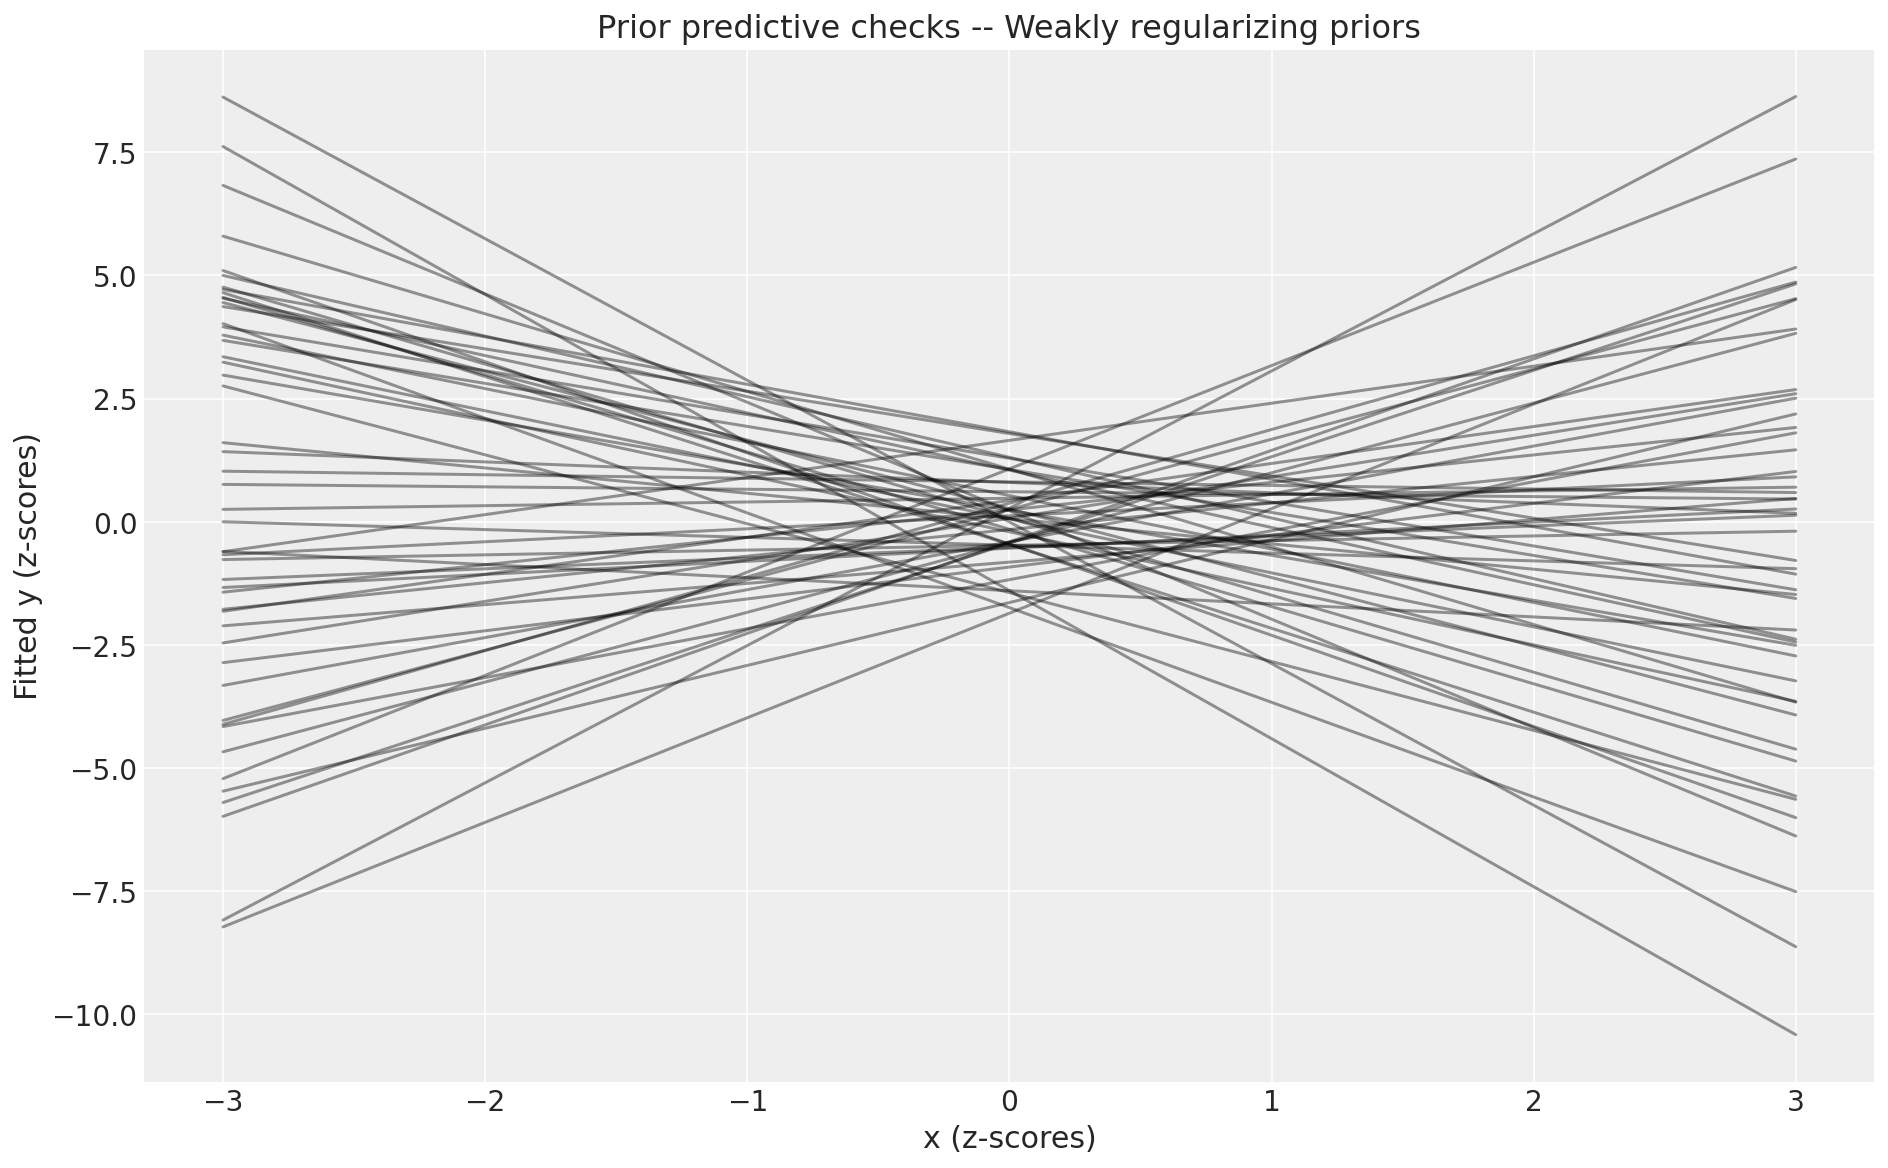

In [47]:
_, ax = plt.subplots(figsize = (13, 8))

x = np.linspace(-3, 3, 200)

for alpha, bAN, bA in zip(fit_iem_df_check["alpha[4]"][:100], fit_iem_df_check["bAN[4]"][:50], fit_iem_df_check["bA"][:100]):
    y = alpha + (bA + bAN) * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("x (z-scores)")
ax.set_ylabel("Fitted y (z-scores)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

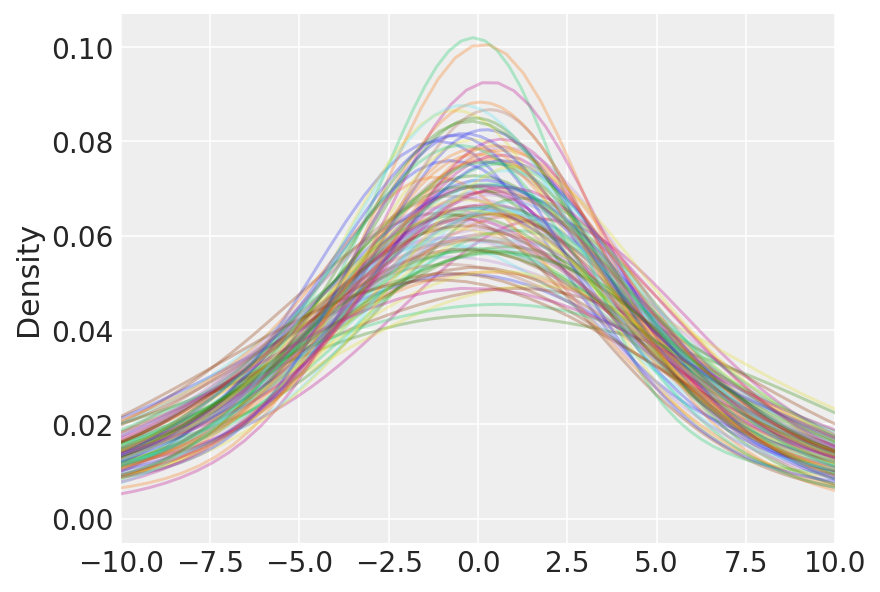

In [39]:
fit_iem_df_check.filter(regex = 'y_hat').T.iloc[:, :100].plot.kde(alpha=0.3,
                                                        legend = False, 
                                                        xlim = (-10, 10));

## Fit model on fake data and recapture known parameters

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


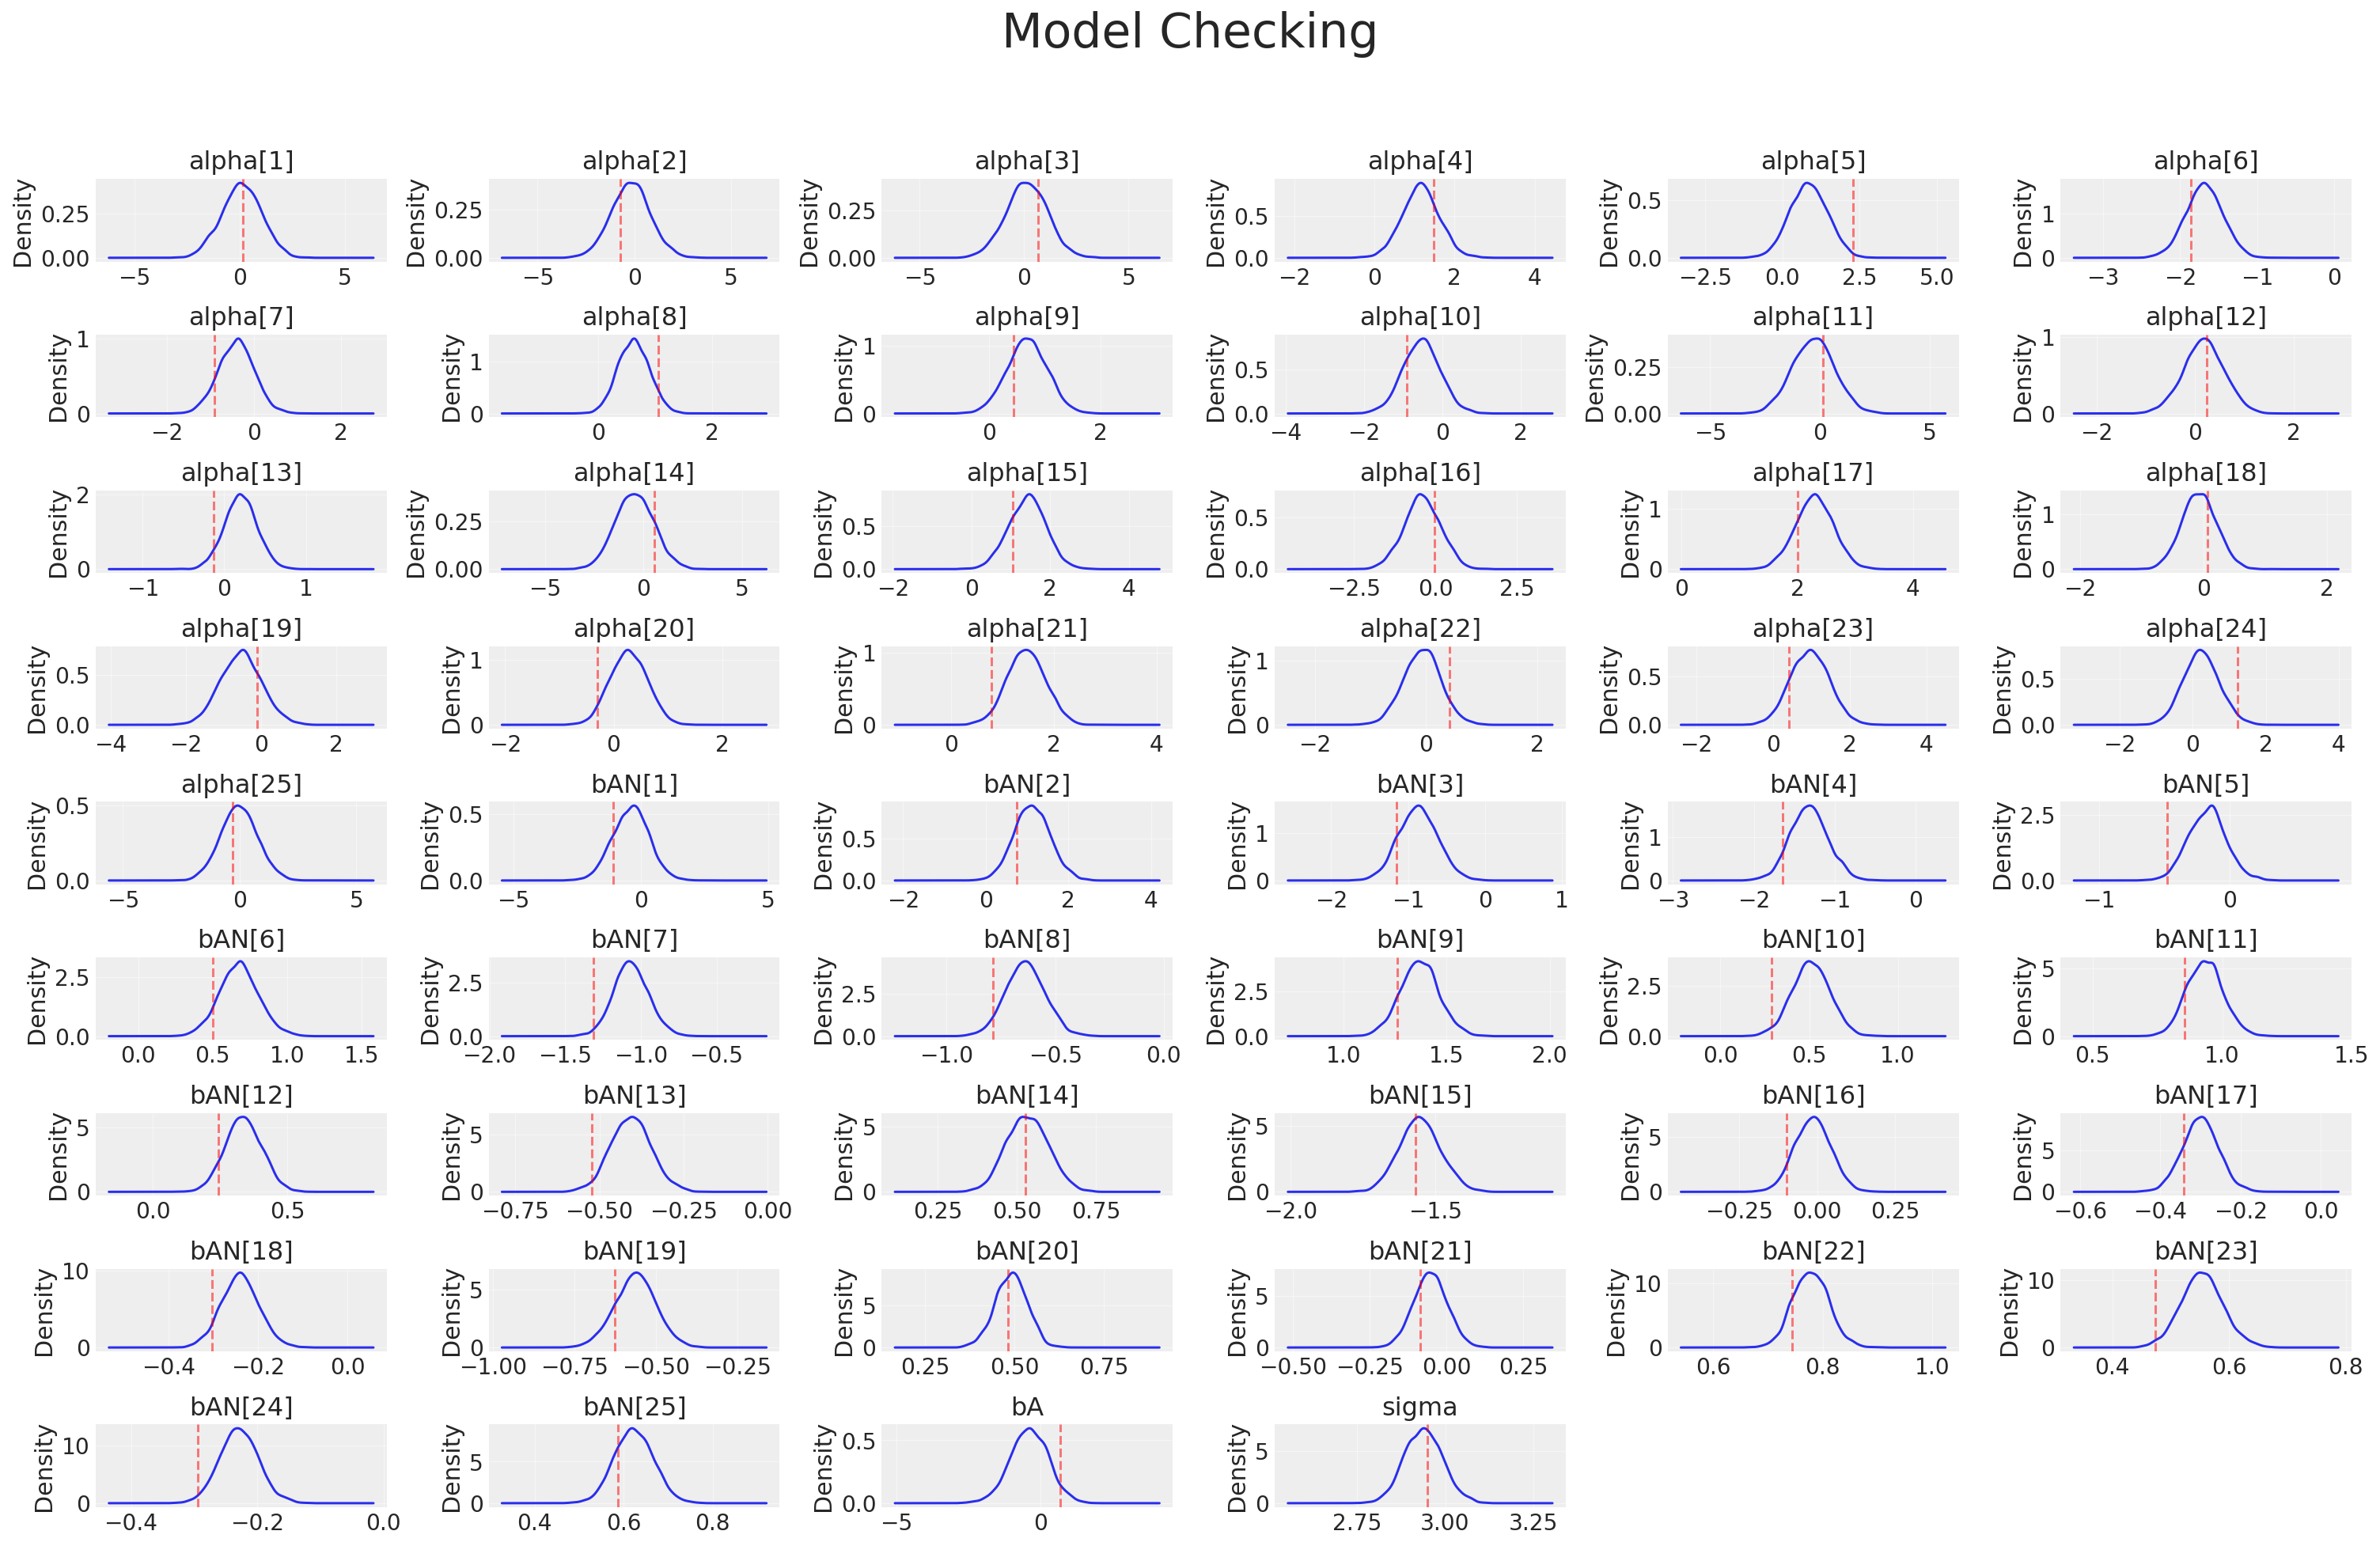

In [40]:
random_draw = 50
y_sim = fit_iem_df_check.filter(regex = 'y_hat').iloc[random_draw, :]
true_parameters = fit_iem_df_check.filter(regex = 'alpha|bA|bAN|sigma').iloc[random_draw, :]

_iem_data_check = dict(N = len(train),
                      neighbourhood = train['neighbourhood'],
                      N_neighbourhood = len(train['Neighborhood'].unique()),
                      log_sales_price = y_sim,
                      log_lot_area = train['log_lot_area_z'],
                      N_test = len(test),
                      neighbourhood_test = test['neighbourhood'],
                      log_lot_area_test = test['log_lot_area_z'],                         
                      alpha_sd = alpha_sd,
                      beta_sd = beta_sd,
                      sigma_sd = sigma_sd,
                      bAN_sd = bAN_sd,
                      run_estimation = 1)

_fit_iem_check = interactive_effects_model.sampling(data=_iem_data_check)
_iem_df_check = _fit_iem_check.to_dataframe()
fake_fit = _iem_df_check.filter(regex = 'alpha|bA|bAN|sigma')
parameter_df = pd.melt(fake_fit)

# Plot
fig, axes = plt.subplots(nrows=max(2, math.ceil(fake_fit.shape[1] / 6)), ncols=6, sharex=False, sharey = False, figsize=(21,13))
fig.suptitle('Model Checking', y = 1.04, size = 30)
axes_list = [item for sublist in axes for item in sublist] 
parameters = parameter_df[['variable']].drop_duplicates().set_index('variable').index
grouped = parameter_df.groupby("variable")

for parameter in parameters:
    selection = grouped.get_group(parameter)
    ax = axes_list.pop(0)
    selection.plot.kde(label=parameter, ax=ax, legend=False)
    ax.set_title(parameter)
    ax.grid(linewidth=0.25)
    ax.axvline(x=true_parameters[parameter], color='red', linestyle='--', alpha = 0.5)

# Now use the matplotlib .remove() method to delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout();

## Fit model on real data

In [41]:
iem_data = dict(N = len(train),
                neighbourhood = train['neighbourhood'],
                N_neighbourhood = len(train['Neighborhood'].unique()),
                log_sales_price = train['log_sales_price_std'],
                log_lot_area = train['log_lot_area_z'],
                N_test = len(test),
                neighbourhood_test = test['neighbourhood'],
                log_lot_area_test = test['log_lot_area_z'],                         
                alpha_sd = alpha_sd,
                beta_sd = beta_sd,
                sigma_sd = sigma_sd,
                bAN_sd = bAN_sd,
                run_estimation = 1)

fit_iem = interactive_effects_model.sampling(data=iem_data)
fit_iem_df = fit_iem.to_dataframe()

iem_az = az.from_pystan(
    posterior=fit_iem,
    posterior_predictive="y_hat",
    observed_data="log_sales_price",
    log_likelihood='log_lik',
)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior predictive checks

<AxesSubplot:xlabel='log_sales_price / y_hat'>

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/IPython/core/events.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


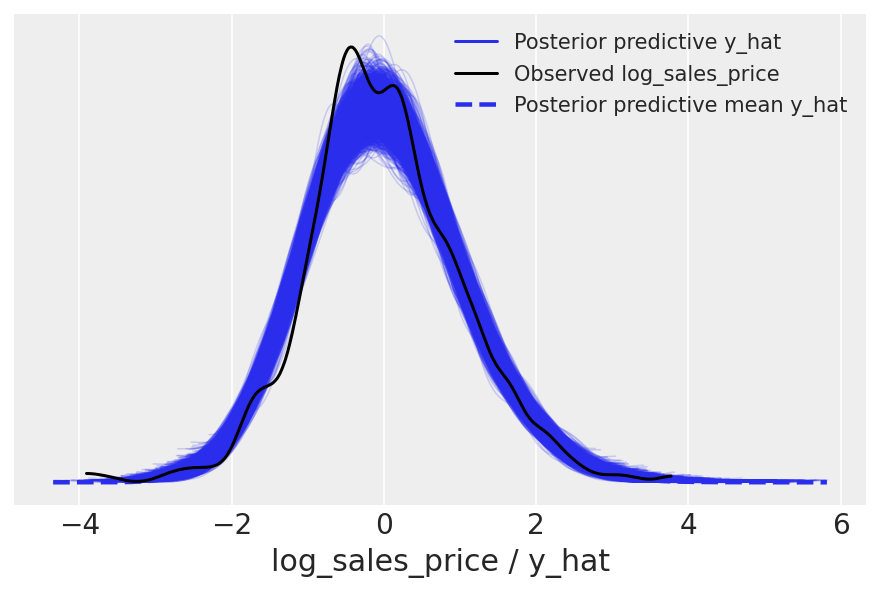

In [42]:
az.plot_ppc(data = iem_az, 
            kind = 'kde', 
            data_pairs = {'log_sales_price' : 'y_hat'})

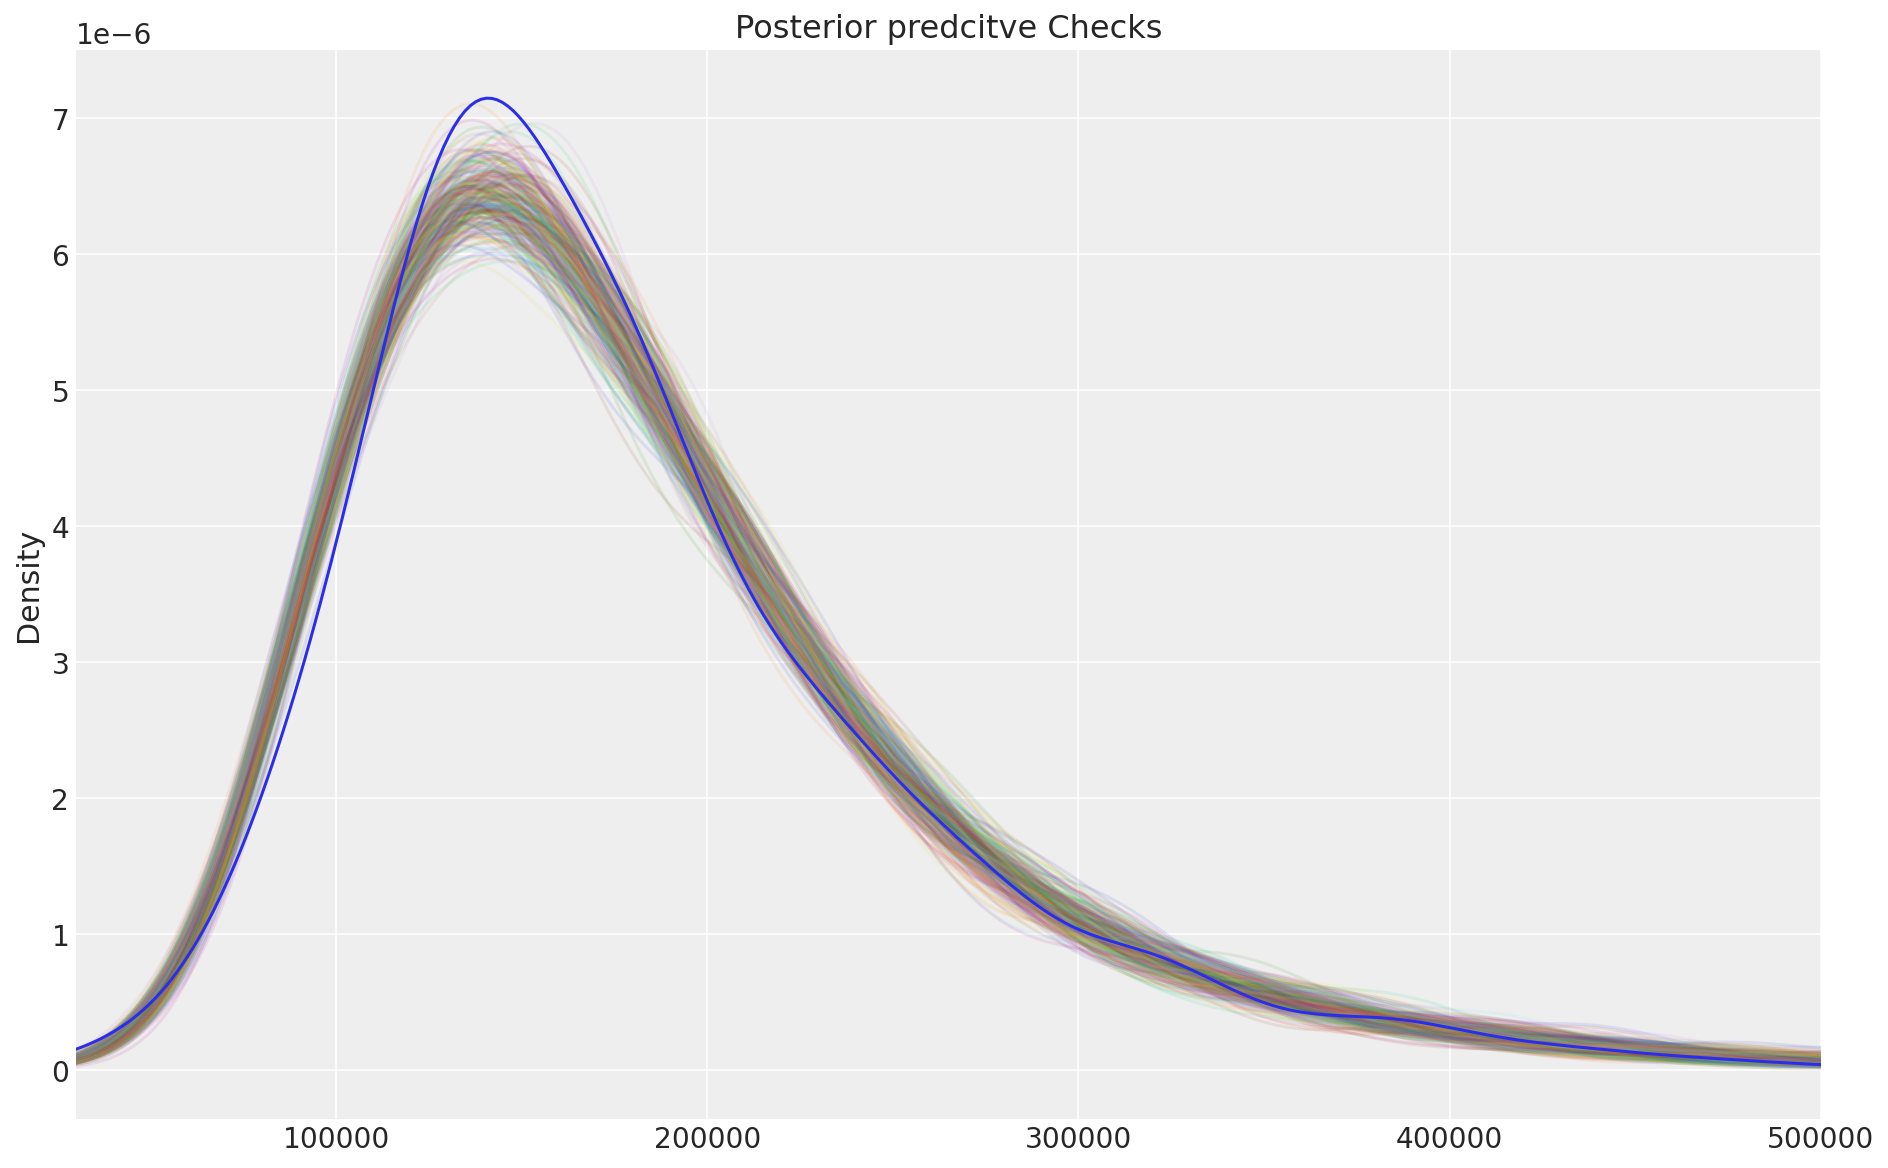

In [43]:
fig, axes = plt.subplots(1,1, figsize = (13, 8))
np.exp(fit_iem_df.filter(regex = 'y_hat')*train['log_sales_price'].std()+train['log_sales_price'].mean()).T.iloc[:, :300].plot.kde(legend = False, 
                                                                                                  title = 'Posterior predcitve Checks', 
                                                                                                  xlim = (30000,500000),
                                                                                                  alpha = 0.1,
                                                                                                  ax = axes);
train['SalePrice'].plot.kde(legend = False, 
                             xlim = (30000,500000),
                             alpha = 1,
                             ax = axes);

In [44]:
az.loo(iem_az, pointwise = True, scale = 'log')

/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/stats.py:932: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/Users/benjaminwee/opt/anaconda3/envs/stan/lib/python3.6/site-packages/arviz/stats/stats.py:684: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 4000 by 1460 log-likelihood matrix

         Estimate       SE
elpd_loo -7793856.56  130154.46
p_loo    3029268.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad) 1460  100.0%

In [45]:
predictions = pd.DataFrame(np.exp(fit_iem_df.filter(regex = 'y_test').mean(axis=0)*train['log_sales_price'].std()+train['log_sales_price'].mean()),
                  columns = ['SalePrice'])\
                  .reset_index()\
                  .drop('index', axis = 1)


saturated_csv = pd.concat([test[['Id']].reset_index().drop('index', axis = 1), 
                                   predictions], axis=1)

saturated_csv.to_csv('../../data/submissions/saturated.csv', index = False)

In [46]:
%%sh
cd ../../data/submissions/;
kaggle competitions submit -c house-prices-advanced-regression-techniques -f saturated.csv -m "saturated model (interactive effects)"

Successfully submitted to House Prices: Advanced Regression Techniques

100%|██████████| 33.7k/33.7k [00:03<00:00, 8.71kB/s]
